# Linear regression model

**How will the algorithm change for finding a solution for a linear model if you add L1 and L2 regularization to the loss function?**<br><br>
*Answer*: Я думаю, что в таком случае модель будет содержать в себе как преимущества Lasso(выбор признаков), так и преимущества Ridge регрессии, при этом эти добавки будут контролировать действие друг друга

**Derive an analytical solution to the regression problem. Use a vector form of the equation**

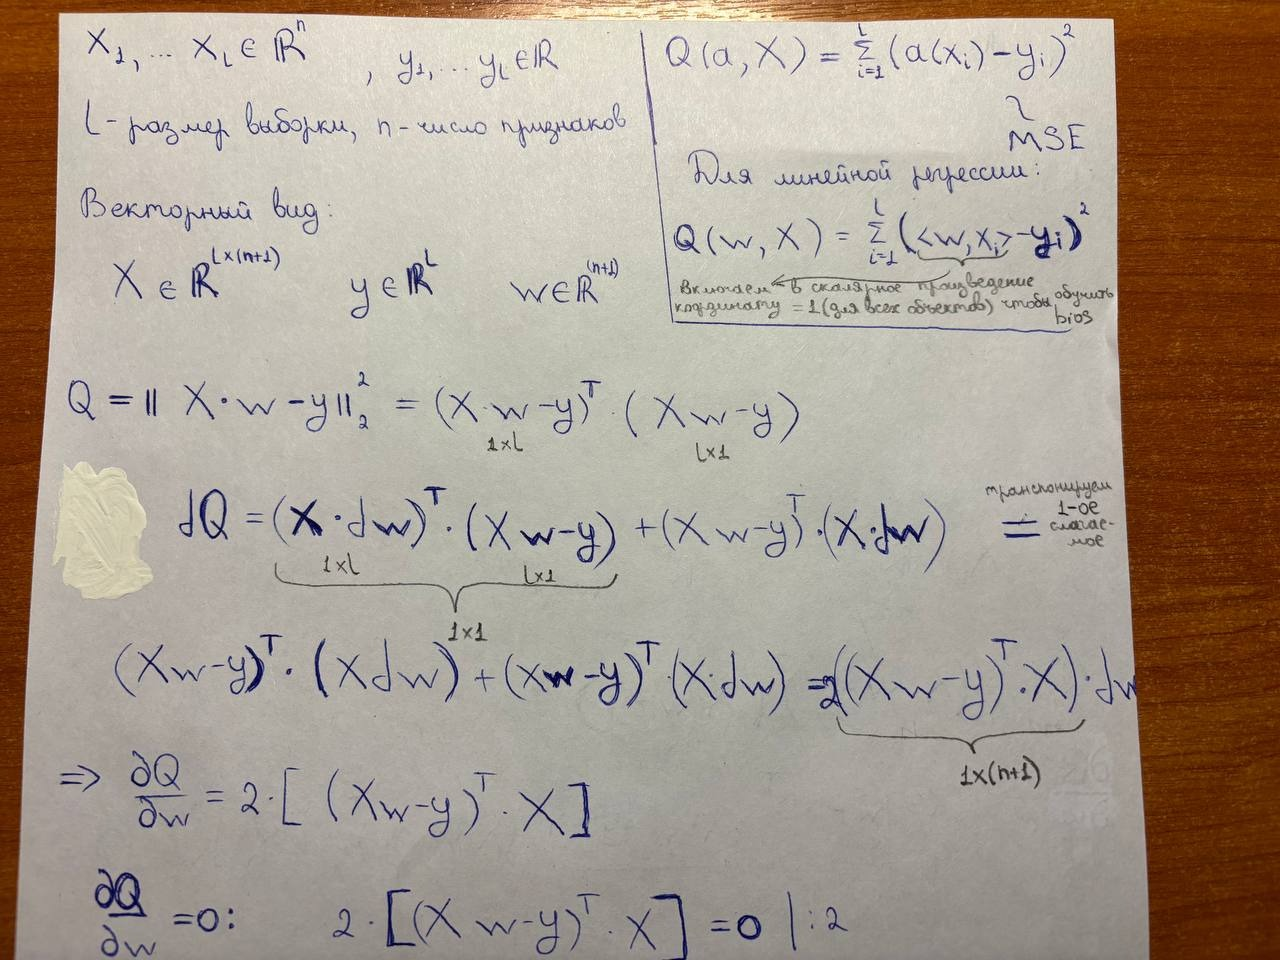

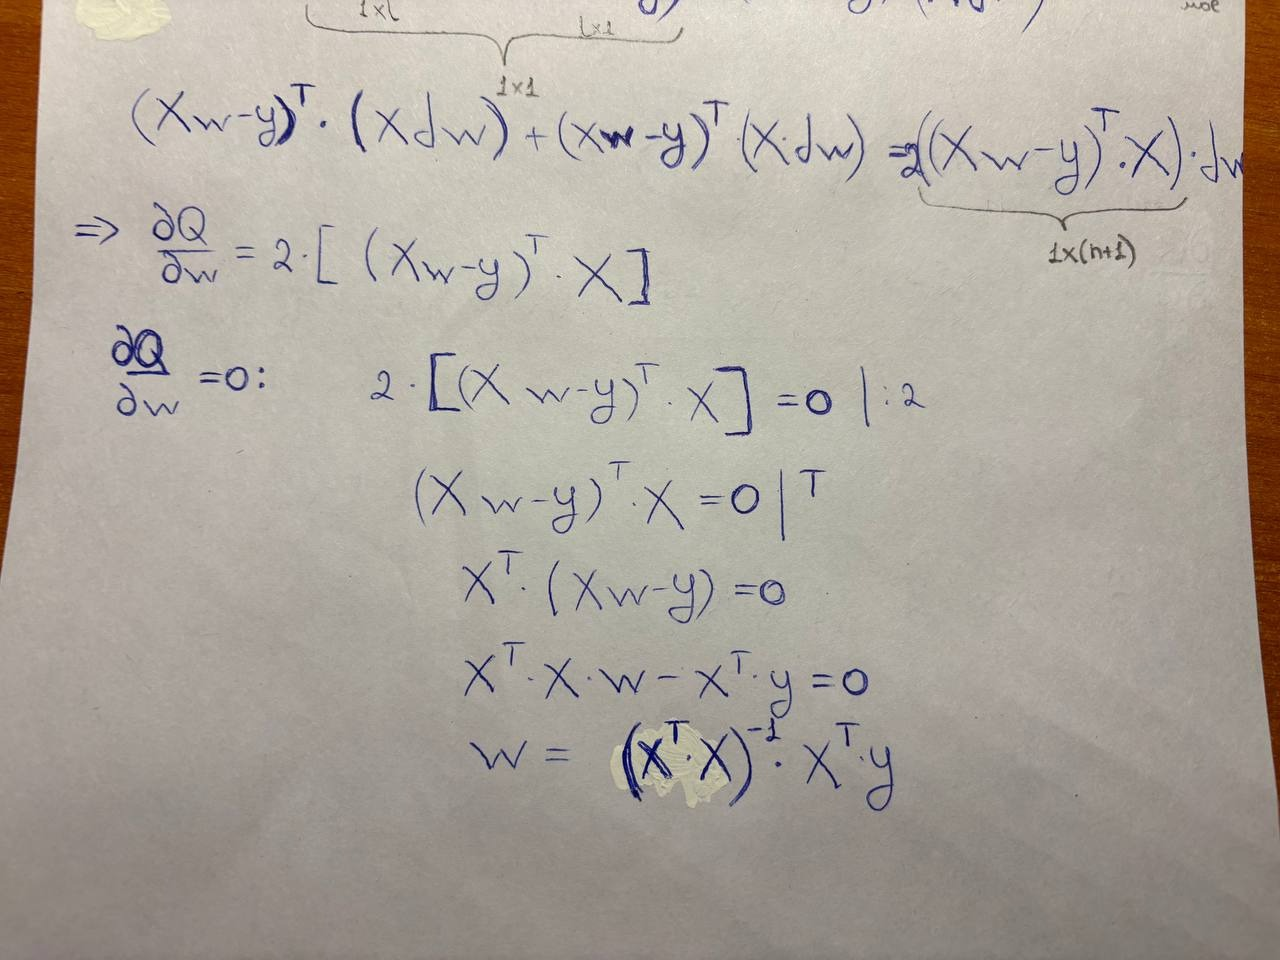

**What changes in the solution when L1 and L2 regularizations are added to the loss function?**

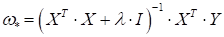

При добавлении $L2$ регуляризации в аналитическое решение задачи регрессии под знаком обратной матрицы появляется слагаемое $λ · I$

Это гарантирует, что матрица $XᵀX + λI$ всегда будет обратимой, даже если $XᵀX$ необратима (например, когда число признаков больше числа объектов или когда есть линейно зависимые признаки)

Для $L1$ регуляризации аналитического решения не существует, поскольку $f(x) = |x|$ не дифференцируема в нуле

**Explain why** $L1$ **regularization is often used to select features. Why are there many weights equal to** $0$ **after the model is fit?**

Чтобы понять, почему это так обратимся к следующему фото:<br><br>

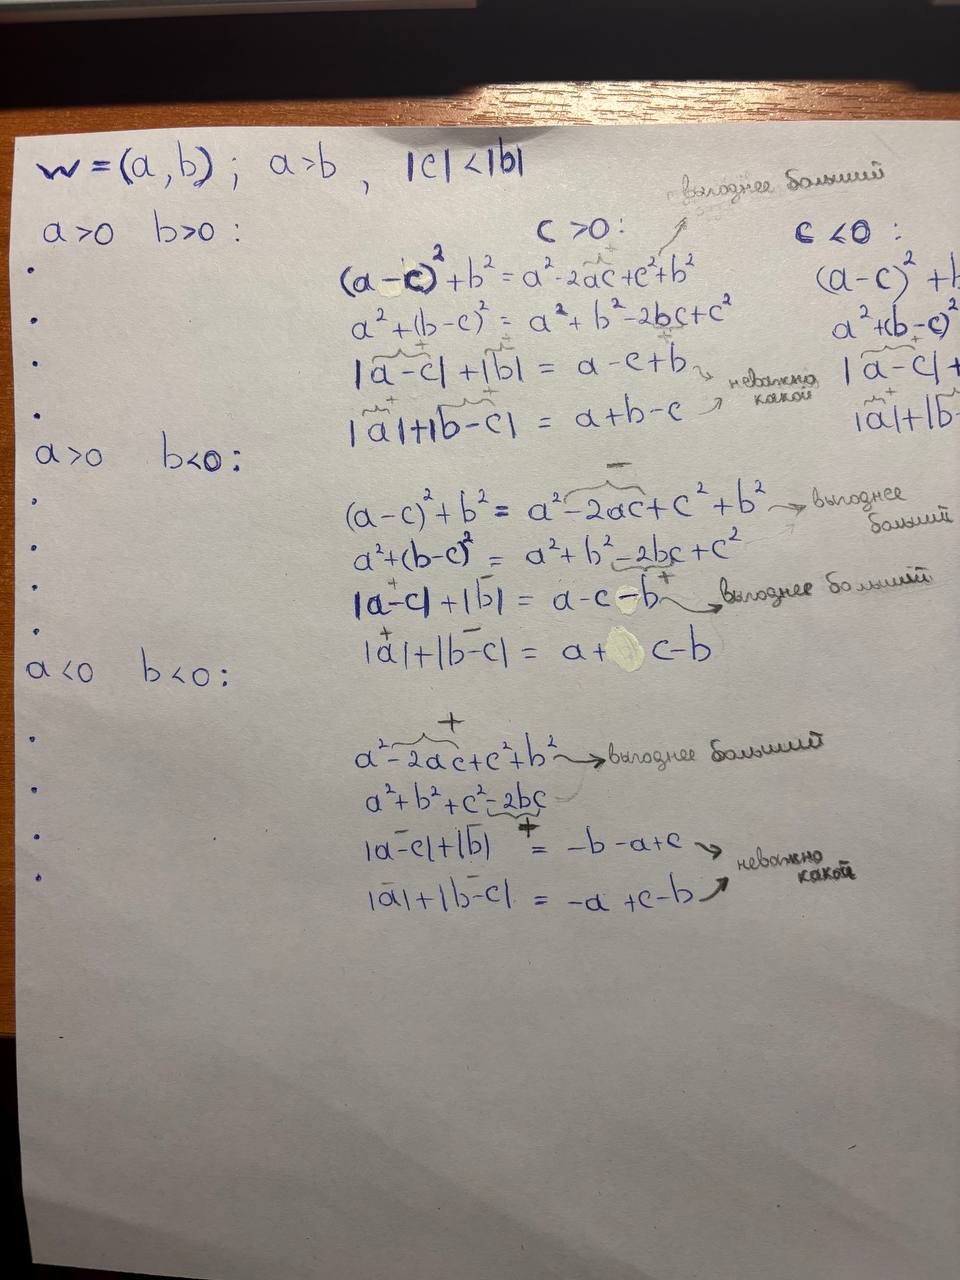

На данном фото мы хотим сделать шаг градиента и посмотреть какую из компонент нам выгоднее уменьшить с точки зрения штрафа регулятора. Из фотографии видно, что в случае $L1$ регуляризации, когда компоненты разных знаков, нам выгодно уменьшать положительную, во всех остальных **безразлично какую из координат сделать меньше, поэтому есть шанс, что меньше станет именно та, что и так близка к нулю**

Для $L2$ регуляризации мы видим, что **выгоднее всегда уменьшать большую** (хотя во втором случае это всегда ведет к уменьшению положительной, а в третьем случае к занулению той, что ближе к нулю)

То есть фактически, для $L1$ регуляризации *компоненты более вероятно станут равными нулю*, чем для $L2$. Поэтому происходит отбор признаков, т. к. ненужные могут занулиться в процессе градиентного спуска

**Explain how you can use the same models (Linear regression, Ridge, etc.) but make it possible to fit nonlinear dependencies**

Этого можно добиться вводя новые признаки объекта как функции от старых признаков. Единственным важным условием является то, что нельзя добавлять линейно зависимые функции. Это ведет к тому, что оптимальных решений будет бесконечное множество и модель, возможно, выберет то, которое имеет большие коэффициенты

### Import libraries

In [1]:
from collections import Counter
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

## Introduction to Data Analysis

In [2]:
def categorical_to_int(x):
    return 0 * (x == "low") + 1 * (x == "medium") + 2 * (x == "high")        

In [3]:
data = pd.read_json("./data/train.json", orient="columns")
data.reset_index(drop=True, inplace=True)
data["interest_level"] = data["interest_level"].apply(categorical_to_int)

test_data = data.sample(frac=0.2, random_state=21)
train_data = data.drop(test_data.index)

del data

test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

train_data.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0
2,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
3,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,0
4,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,7200,145 East 16th Street,0


In [4]:
test_data.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,2,c94301249b8c09429d329864d58e5b82,2016-06-17 06:11:41,Massive flex 2 penthouse offers light-filled r...,Gold Street,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",40.7074,7178315,-74.0069,69f035007d270281a624ab2cc1d2aba0,[https://photos.renthop.com/2/7178315_1f5a6e24...,3750,2 Gold Street,0
1,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-01 06:16:10,"THE APT-LARGE FLEX 2,KING SIZE ROOMS,OVER SIZE...",East 56th Street,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7575,7093824,-73.9625,293a5d2579bc2eb7b20736ae2395e9e5,[https://photos.renthop.com/2/7093824_fd31ad00...,3500,405 East 56th Street,1
2,1.0,0,51466f9127f3a4c45f4b84ec40739606,2016-06-16 02:26:00,Classic West Village Studio on Charles St. Out...,Charles Street,"[Garden/Patio, Loft, Dishwasher, Hardwood Floo...",40.7344,7167172,-74.0057,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7167172_505e2cac...,2425,108 Charles Street,0
3,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-21 03:25:36,NO FEE!!!! 1BR/1BA with granite counter tops a...,East 49th Street,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7539,6905526,-73.9677,9d32b720e26a351b951c8f78f72f2fec,[https://photos.renthop.com/2/6905526_08947ee5...,3600,333 East 49th Street,0
4,2.0,2,ed522b45f275b7f2d6261575638e75d0,2016-05-13 02:50:12,ELEVATOR - LAUNDRY - SS APPLIANCES - RECESSED ...,St. Nicholas Avenue,"[Elevator, Dogs Allowed, Cats Allowed]",40.8322,7005178,-73.9412,23fe9db389d31048a104bd4686879a77,[https://photos.renthop.com/2/7005178_00651c09...,2700,935 St. Nicholas Avenue,0


## Intro data analysis part 2

In [5]:
def get_features(df):
    features, iterator = list(), df.iterrows()

    for (index, row) in iterator:
        curr_features = row["features"]
        features.extend([(x.replace(" ", "")).replace(",", "") for x in curr_features])

    return features

In [6]:
features = get_features(train_data)
features.extend(get_features(test_data))

print(len(set(features)))

1548


In [7]:
func = lambda curr_features: ",".join([x.replace(" ", "") for x in curr_features])
train_data["features"] = train_data["features"].apply(func)
test_data["features"] = test_data["features"].apply(func)

train_data.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"DiningRoom,Pre-War,LaundryinBuilding,Dishwashe...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,1
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"Doorman,Elevator,LaundryinBuilding,Dishwasher,...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,0
2,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,1
3,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"Doorman,Elevator,FitnessCenter,LaundryinBuilding",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,0
4,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"Doorman,Elevator,Loft,Dishwasher,HardwoodFloor...",40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,7200,145 East 16th Street,0


In [8]:
counter = Counter(features)

counter.most_common(20)

[('Elevator', 25915),
 ('CatsAllowed', 23540),
 ('HardwoodFloors', 23527),
 ('DogsAllowed', 22035),
 ('Doorman', 20898),
 ('Dishwasher', 20426),
 ('NoFee', 18062),
 ('LaundryinBuilding', 16344),
 ('FitnessCenter', 13252),
 ('Pre-War', 9148),
 ('LaundryinUnit', 8738),
 ('RoofDeck', 6542),
 ('OutdoorSpace', 5268),
 ('DiningRoom', 5136),
 ('HighSpeedInternet', 4299),
 ('Balcony', 2992),
 ('SwimmingPool', 2730),
 ('LaundryInBuilding', 2593),
 ('NewConstruction', 2559),
 ('Terrace', 2283)]

In [9]:
feature_list = ['Elevator', 'CatsAllowed', 'HardwoodFloors', 'DogsAllowed', 'Doorman', 'Dishwasher', 'NoFee', 'LaundryinBuilding',
                'FitnessCenter', 'Pre-War', 'LaundryinUnit', 'RoofDeck', 'OutdoorSpace', 'DiningRoom', 'HighSpeedInternet', 'Balcony',
                'SwimmingPool', 'LaundryInBuilding', 'NewConstruction', 'Terrace', 'bathrooms', 'bedrooms', 'interest_level']

schema = {'Elevator': int, 'CatsAllowed': int, 'HardwoodFloors': int, 'DogsAllowed': int, 'Doorman': int, 'Dishwasher': int, 'NoFee': int,
          'LaundryinBuilding': int, 'FitnessCenter': int, 'Pre-War': int, 'LaundryinUnit': int, 'RoofDeck': int, 'OutdoorSpace': int, 
          'DiningRoom': int, 'HighSpeedInternet': int, 'Balcony': int, 'SwimmingPool': int, 'LaundryInBuilding': int, 'NewConstruction': int,
          'Terrace': int, 'bathrooms': float, 'bedrooms': int, 'interest_level': int, 'price': float}

def transform_data(df):
    columns = feature_list + ["price"]
    final_df, iterator = pd.DataFrame(columns=columns), df.iterrows()
    cat_features = feature_list[:(-3)]

    for (index, row) in iterator:
        curr_features, curr_row = set(row["features"].split(",")), []
        for elem in cat_features:
            curr_row.append(1 if elem in curr_features else 0)
        curr_row.extend([row["bathrooms"], row["bedrooms"], row["interest_level"], row["price"]])

        final_df.loc[index] = curr_row
    
    return final_df.astype(schema)

In [10]:
train_data = transform_data(train_data)
train_data.head(5)

,Elevator,CatsAllowed,HardwoodFloors,DogsAllowed,Doorman,Dishwasher,NoFee,LaundryinBuilding,FitnessCenter,Pre-War,...,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace,bathrooms,bedrooms,interest_level,price
0,0,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,1.0,1,1,2400.0
1,1,0,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1.0,2,0,3800.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.5,3,1,3000.0
3,1,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1.0,0,0,2795.0
4,1,0,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1.0,3,0,7200.0


In [11]:
test_data = transform_data(test_data)
test_data.head(5)

,Elevator,CatsAllowed,HardwoodFloors,DogsAllowed,Doorman,Dishwasher,NoFee,LaundryinBuilding,FitnessCenter,Pre-War,...,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace,bathrooms,bedrooms,interest_level,price
0,1,1,1,1,1,1,1,1,1,0,...,0,0,1,0,0,0,1.0,2,0,3750.0
1,1,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,1.0,2,1,3500.0
2,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1.0,0,0,2425.0
3,1,0,1,0,1,1,1,1,1,0,...,0,0,0,0,0,0,1.0,1,0,3600.0
4,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2.0,2,0,2700.0


## Models implementation — Linear regression

In [12]:
class Stochastic_linreg:
    def __init__(self, max_iter=1000, eta=0.01, T=1500, verbose=False):
        self.max_iter = max_iter
        self.eta = eta
        self.T = T
        self.w = None
        self.verbose = verbose
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0

        d = X_train.shape[1] # размерность признакового пространства
        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        w = np.random.normal(scale=0.1, size=d) # генерируем начальное положение весов в признаковом пространстве

        if self.verbose:
            Q = [] # тут будут храниться значений для график Q

        eta = self.eta
        
        for i in range(self.max_iter):
            rand_sample = random.randrange(l) # выбираем случайный элемент из выборки
            curr_x, curr_y = X[rand_sample], y[rand_sample]

            for_q = curr_x @ w.T - curr_y
            grad_q = (2 * for_q) * curr_x # вычисляем значение градиента для конкретного q(x_i, w)

            w = w - grad_q * eta

            if self.verbose and i % 80 == 0:
                for_Q = (X @ w.T) - y.T
                curr_Q = (1 / l) * for_Q.T @ for_Q # вычисляем функционал качества для текущей точки
                Q.append(curr_Q)

            eta = self.eta * np.exp(-i / self.T)

        if self.verbose:
            plt.plot(Q)
        
        self.w = w

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

In [13]:
class Full_linreg:
    def __init__(self, max_iter=1500, eta=0.01, T=2200, verbose=False):
        self.max_iter = max_iter
        self.eta = eta
        self.T = T
        self.w = None
        self.verbose = verbose
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0

        d = X_train.shape[1] # размерность признакового пространства
        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        w = np.random.normal(scale=0.1, size=d) # генерируем начальное положение весов в признаковом пространстве

        eta = self.eta

        if self.verbose:
            Q = list() # тут будут храниться значения для графика
        
        for i in range(self.max_iter):
            for_Q = (X @ w.T) - y.T

            grad_Q = (2 / l) * X.T @ for_Q # вычисляем значение градиента в текущей точке
            w = w - grad_Q * eta

            eta = self.eta * np.exp(-i / self.T)

            if self.verbose and i % 80 == 0:
                curr_Q = (1 / l) * for_Q.T @ for_Q # вычисляем функционал качества для текущей точки
                Q.append(curr_Q)

        if self.verbose:
            plt.plot(Q)
        
        self.w = w

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

In [14]:
class Analytical_linreg:
    def __init__(self):
        self.w = None
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0

        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

In [15]:
def calculate_r2(y_true, y_pred):

    if type(y_true) == pd.DataFrame or type(y_true) == pd.Series:
        y = y_true.values
    elif type(y_true) == np.ndarray:
        y = y_true
    else:
        raise ValueError("Incorrect type of the y true values")
        
    if type(y_pred) == pd.DataFrame or type(y_pred) == pd.Series:
        predicts = y_pred.values
    elif type(y_pred) == np.ndarray:
        predicts = y_pred
    else:
        raise ValueError("Incorrect type of the y pred values")
        
    mean_y = np.mean(y)

    return 1 - (np.sum((predicts - y) ** 2) / np.sum((y - mean_y) ** 2))

In [16]:
def calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, name, pos):
    train_predicts = model.predict(train_data.iloc[:, :(-1)])
    test_predicts = model.predict(test_data.iloc[:, :(-1)])

    test_mae = mean_absolute_error(test_data.iloc[:, -1], test_predicts)
    train_mae = mean_absolute_error(train_data.iloc[:, -1], train_predicts)
    mae_row = [name, train_mae, test_mae]

    test_rmse = root_mean_squared_error(test_data.iloc[:, -1], test_predicts)
    train_rmse = root_mean_squared_error(train_data.iloc[:, -1], train_predicts)
    rmse_row = [name, train_rmse, test_rmse]

    test_r2 = calculate_r2(test_data.iloc[:, -1], test_predicts)
    train_r2 = calculate_r2(train_data.iloc[:, -1], train_predicts)
    r2_row = [name, train_r2, test_r2]
    
    MAE_table.loc[pos] = mae_row
    RMSE_table.loc[pos] = rmse_row
    R2_table.loc[pos] = r2_row

In [17]:
columns = ["model", "train", "test"]
types = {"model": str, "train": float, "test": float}

MAE_table = pd.DataFrame(columns=columns).astype(types)
RMSE_table = pd.DataFrame(columns=columns).astype(types)
R2_table = pd.DataFrame(columns=columns).astype(types)

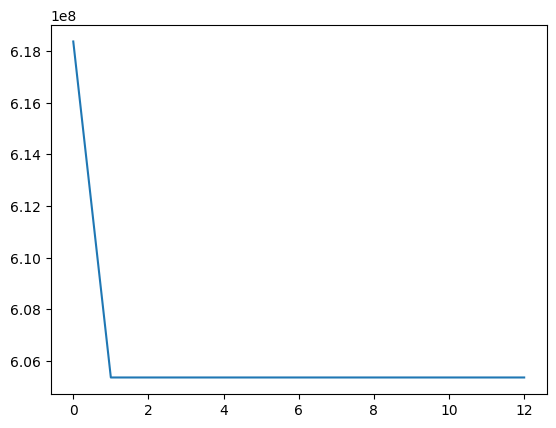

In [18]:
model = Stochastic_linreg(verbose=True, T=10)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "stochastic_lin_reg", 0)

In [19]:
model = Analytical_linreg()
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "analytical_lin_reg", 1)

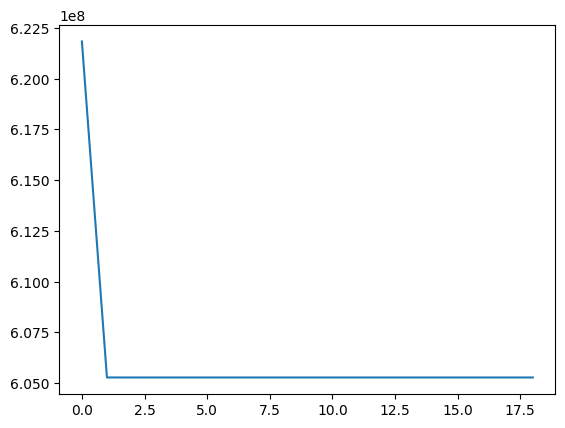

In [20]:
model = Full_linreg(verbose=True, T=10)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "full_lin_reg", 2)

In [21]:
model = LinearRegression(n_jobs=(-1))
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "sklearn_lin_reg", 3)

In [22]:
MAE_table

,model,train,test
0,stochastic_lin_reg,1269.672986,1062.192794
1,analytical_lin_reg,1229.303686,1028.137185
2,full_lin_reg,1191.215578,981.859891
3,sklearn_lin_reg,1229.303686,1028.137185


In [23]:
RMSE_table

,model,train,test
0,stochastic_lin_reg,24604.087393,2353.237114
1,analytical_lin_reg,24564.864492,2175.172368
2,full_lin_reg,24602.248321,2340.430972
3,sklearn_lin_reg,24564.864492,2175.172368


In [24]:
R2_table

,model,train,test
0,stochastic_lin_reg,0.002490,0.224483
1,analytical_lin_reg,0.005668,0.337406
2,full_lin_reg,0.002640,0.232900
3,sklearn_lin_reg,0.005668,0.337406


## Regularized models implementation — Ridge, Lasso, ElasticNet

In [25]:
class Ridge_linreg:
    def __init__(self, beta=0.1, verbose=False):
        self.w = None # вектор весов обученной модели
        self.beta = beta # коэффициент регуляризации
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0
        
        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        d = X.shape[1]
        
        E = np.eye(d)
        E[0][0] = 0 # нельзя обучать bias
                    
        self.w = np.linalg.inv(X.T @ X + self.beta * E) @ X.T @ y

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

In [26]:
model = Ridge_linreg(verbose=True)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "ridge_lin_reg", 4)

In [27]:
model = Ridge(alpha=0.1)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "sklearn_ridge_lin_reg", 5)

In [28]:
class Lasso_linreg:
    def __init__(self, max_iter=1000, eta=0.01, T=1500, beta=0.1, verbose=False):
        self.max_iter = max_iter # максимальное количество итераций для алгоритма
        self.eta = eta # начальный learning rate
        self.T = T # параметр отвечающий за скорость уменьшения learing rate
        self.w = None # вектор весов обученной модели
        self.beta = beta # коэффициент регуляризации
        self.verbose = verbose # если True, то будет выведен график для функционала
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0

        d = X_train.shape[1] # размерность признакового пространства
        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        w = np.random.normal(scale=0.1, size=d) # генерируем начальное положение весов в признаковом пространстве

        if self.verbose:
            Q = list() # тут будут храниться значения для графика

        eta = self.eta
        
        for i in range(self.max_iter):
            rand_sample = random.randrange(l) # выбираем случайный элемент из выборки
            curr_x, curr_y = X[rand_sample], y[rand_sample]

            for_q = curr_x @ w.T - curr_y
            grad_q = (2 * for_q) * curr_x # вычисляем значение градиента для конкретного q(x_i, w)

            w[0] = w[0] - eta * grad_q[0]  # нельзя использовать регуляризацию для bias
            w[1:] = w[1:] - eta * (grad_q[1:] + self.beta * np.sign(w[1:]))

            if self.verbose and i % 80 == 0:
                for_Q = (X @ w.T) - y.T
                curr_Q = (1 / l) * (for_Q.T @ for_Q) + self.beta * np.sum(np.abs(w[1:]))
                Q.append(curr_Q)
                
            eta = self.eta * np.exp(-i / self.T)

        if self.verbose:
            plt.plot(Q)
                    
        self.w = w

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

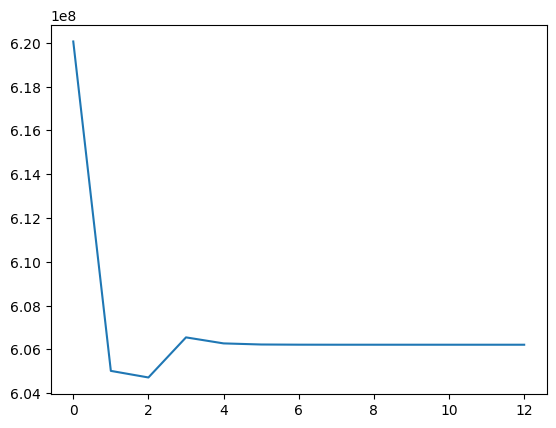

In [29]:
model = Lasso_linreg(verbose=True, T=50)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "lasso_lin_reg", 6)

In [30]:
model = Lasso(alpha=0.1)
model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])

calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "sklearn_lasso_lin_reg", 7)

In [31]:
class ElasticNet_linreg:
    def __init__(self, max_iter=1000, eta=0.01, T=1500, beta=0.1, l1_ratio=0.1, verbose=False):
        self.max_iter = max_iter # максимальное количество итераций для алгоритма
        self.eta = eta # начальный learning rate
        self.T = T # параметр отвечающий за скорость уменьшения learing rate
        self.w = None # вектор весов обученной модели
        self.beta = beta # коэффициент регуляризации для l2 нормы
        self.l1_ratio = l1_ratio # коэффициент регуляризации для l1 нормы
        self.verbose = verbose # если True, то будет выведен график для функционала
    
    def fit(self, X_train, y_train):
        l = len(X_train) # размер выборки
        
        if l == 0:
            self.w = None
            
        const_column = pd.Series(data=np.full(l, fill_value=1), name="const_feature")
        X_train = pd.concat([const_column, X_train], axis=1) # добавляем постоянный признак, всегда равный 1 для обучения w_0

        d = X_train.shape[1] # размерность признакового пространства
        X, y = X_train.values.astype(float), y_train.values # получаем матрицу и столбец наших данных
        w = np.random.normal(scale=0.1, size=d) # генерируем начальное положение весов в признаковом пространстве

        if self.verbose:
            Q = list() # тут будут храниться значения для графика

        eta = self.eta
        
        for i in range(self.max_iter):
            rand_sample = random.randrange(l) # выбираем случайный элемент из выборки
            curr_x, curr_y = X[rand_sample], y[rand_sample]

            for_q = curr_x @ w.T - curr_y
            grad_q = (2 * for_q) * curr_x # вычисляем значение градиента для конкретного q(x_i, w)

            w[0] = w[0] - eta * grad_q[0]  # нельзя использовать регуляризацию для bias
            w[1:] = w[1:] - eta * (grad_q[1:] + self.beta * self.l1_ratio * np.sign(w[1:]) + self.beta * (1 - self.l1_ratio) * w[1:])

            if self.verbose and i % 80 == 0:
                for_Q = (X @ w.T) - y.T
                curr_Q = (1 / l) * (for_Q.T @ for_Q) + 0.5 * self.beta * (1 - self.l1_ratio) * np.sum(w[1:] ** 2) + self.beta * self.l1_ratio * np.sum(np.abs(w[1:]))
                Q.append(curr_Q)
                
            eta = self.eta * np.exp(-i / self.T)

        if self.verbose:
            plt.plot(Q)
                    
        self.w = w

    def predict(self, X_test):
        if self.w is None:
            raise "You didn't fit your model before making predictions"

        X_test = X_test.values
        X_test = np.insert(X_test, 0, 1, axis=1)

        return X_test @ self.w

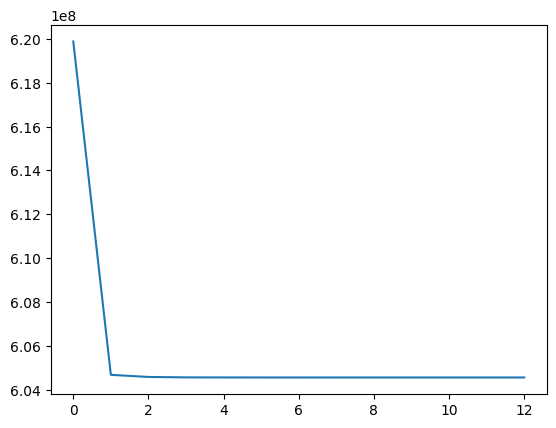

In [32]:
model = ElasticNet_linreg(verbose=True, T=50)

model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])
calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "elasticnet_lin_reg", 8)

In [33]:
model = ElasticNet(alpha=0.1, l1_ratio=0.1)

model.fit(train_data.iloc[:, :(-1)], train_data.iloc[:, -1])
calculate_metrics(model, train_data, test_data, MAE_table, RMSE_table, R2_table, "sklearn_elasticnet_lin_reg", 9)

In [34]:
MAE_table

,model,train,test
0,stochastic_lin_reg,1269.672986,1062.192794
1,analytical_lin_reg,1229.303686,1028.137185
2,full_lin_reg,1191.215578,981.859891
3,sklearn_lin_reg,1229.303686,1028.137185
4,ridge_lin_reg,1229.296715,1028.129507
5,sklearn_ridge_lin_reg,1229.296715,1028.129507
6,lasso_lin_reg,2029.685392,1812.247223
7,sklearn_lasso_lin_reg,1228.887726,1027.669867
8,elasticnet_lin_reg,1219.328530,1006.622080
9,sklearn_elasticnet_lin_reg,1135.458244,926.995105


In [35]:
RMSE_table

,model,train,test
0,stochastic_lin_reg,24604.087393,2353.237114
1,analytical_lin_reg,24564.864492,2175.172368
2,full_lin_reg,24602.248321,2340.430972
3,sklearn_lin_reg,24564.864492,2175.172368
4,ridge_lin_reg,24564.864492,2175.168515
5,sklearn_ridge_lin_reg,24564.864492,2175.168515
6,lasso_lin_reg,24621.403821,2734.428846
7,sklearn_lasso_lin_reg,24564.864577,2174.951685
8,elasticnet_lin_reg,24585.606887,2249.778044
9,sklearn_elasticnet_lin_reg,24568.700601,2149.802926


In [36]:
R2_table

,model,train,test
0,stochastic_lin_reg,0.002490,0.224483
1,analytical_lin_reg,0.005668,0.337406
2,full_lin_reg,0.002640,0.232900
3,sklearn_lin_reg,0.005668,0.337406
4,ridge_lin_reg,0.005668,0.337408
5,sklearn_ridge_lin_reg,0.005668,0.337408
6,lasso_lin_reg,0.001086,-0.047113
7,sklearn_lasso_lin_reg,0.005668,0.337540
8,elasticnet_lin_reg,0.003988,0.291174
9,sklearn_elasticnet_lin_reg,0.005358,0.352772


## Feature normalization

**Why and where feature normalization is mandatory and vice versa?**

1) Прежде всего она нужно для того, что градиентный спуск чувствовал изменение каждого признака модели одинаково. При градиентном спуске *каждый вес обновляется на величину, пропорциональную производной функции потерь по этому весу*. Если *один признак* имеет *очень большой масштаб*, то *небольшое изменение этого признака* может ```сильно повлиять на функцию потерь```. Это приводит к тому, что *производная по соответствующему весу также будет большой*. Напротив, если *другой признак имеет очень маленький масштаб*, то *даже большое изменение этого признака* может ```оказывать лишь незначительное влияние на функцию потерь```. Производная по соответствующему весу будет маленькой.
В результате веса, соответствующие большим признакам, будут изменяться гораздо быстрее, чем веса, соответствующие маленьким признакам
<br><br>Конкретные модели, которым нужна нормализация признаков:
* Линейные
* Нейронные сети
* Логистическая регрессия

2) Это также важно *для алгоритма кластеризации K-Means*. Он основан на вычислении K центроидов среди данных. Для этого используется расстояние среди них, НО *если некоторые признаки будут иметь большой масштаб*, то алгоритм будет давай плохие результаты (```такие признаки станут доминирующими и затмят остальные```)
3) Это важно для алгоритмов регуляризации. Модель может придать значение признакам с большими весами, но тогда совершенно теряется смысл регуляризации

**Когда влияние негативно или отсутствует?**

1) Алгоритмы, которые используют конкретное распределение данных могут ухудшить свою работоспособность из-за изменения признаков, это будет вести к тому что распределение случайных величин исказится
2) Если признаки уже отмасштабированы и лежат в $[0; 1]$, то дальнейшее их изменение может негативно сказать на их распределении
3) Для решающих деревьев и случайных лесов это совершенно не имеет никакого значения, поскольку они используют пороговое значение на основе данных

Преобразование ```MinMaxScaler``` для отдельного значения признака ```x``` вычисляется по следующей формуле:

$x_{scaled} = (x - x_{min}) / (x_{max} - x_{min})$

где:

* $x$ — исходное значение признака
* $x_{min}$ — минимальное значение признака в обучающей выборке
* $x_{max}$ — максимальное значение признака в обучающей выборке
* $x_{scaled}$ — масштабированное значение признака, лежащее в диапазоне от $0$ до $1$

In [37]:
def min_max_scaler(X, a=0, b=1, copy=True):
    if type(X) == pd.DataFrame:
        if copy:
            res = pd.DataFrame()
        else:
            res = X
        
        for column in X:
            x_min, x_max = X[column].min(), X[column].max()
            if (x_max - x_min) == 0:
                l = len(X[column])
                new_column = pd.Series(data=np.full(l, fill_value=a), name=column)
            else:
                x_std = (X[column] - x_min) / (x_max - x_min)
                new_column = x_std * (b - a) + a

            res[column] = new_column
    elif type(X) in [pd.Series, np.ndarray]:
        x_min, x_max = X.min(), X.max()
        if (x_max - x_min) == 0:
            res = np.full(len(X), fill_value=a)
            if type(X) == pd.Series:
                res = pd.Series(res)
        else:
            x_std = (X - x_min) / (x_max - x_min)
            res = x_std * (b - a) + a
    else:
        return None

    return res

In [38]:
min_max_scaler(train_data)

,Elevator,CatsAllowed,HardwoodFloors,DogsAllowed,Doorman,Dishwasher,NoFee,LaundryinBuilding,FitnessCenter,Pre-War,...,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace,bathrooms,bedrooms,interest_level,price
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125,0.5,0.000525
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250,0.0,0.000837
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.375,0.5,0.000659
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000,0.0,0.000613
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.375,0.0,0.001594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39477,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.250,0.0,0.000947
39478,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125,0.5,0.000792
39479,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000,0.0,0.000475
39480,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.375,0.0,0.000614


In [39]:
scaler = MinMaxScaler()

pd.DataFrame(scaler.fit_transform(train_data))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125,0.5,0.000525
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.250,0.0,0.000837
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.375,0.5,0.000659
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000,0.0,0.000613
4,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.375,0.0,0.001594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39477,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.20,0.250,0.0,0.000947
39478,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.125,0.5,0.000792
39479,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.000,0.0,0.000475
39480,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.375,0.0,0.000614


In [40]:
def standard_scaler(X, copy=True):
    if type(X) == pd.DataFrame:
        if copy:
            res = pd.DataFrame()
        else:
            res = X
        
        for column in X:
            mean, std = X[column].mean(), X[column].std()
            if std != 0:            
                res[column] = (X[column] - mean) / std
            else:
                res[column] = X[column]
            
    elif type(X) in [pd.Series, np.ndarray]:
        mean, std = X.mean(), X.std()
        if std != 0:
            res = (X - mean) / std
        else:
            res = X
    else:
        return None

    return res

In [41]:
standard_scaler(train_data)

,Elevator,CatsAllowed,HardwoodFloors,DogsAllowed,Doorman,Dishwasher,NoFee,LaundryinBuilding,FitnessCenter,Pre-War,...,HighSpeedInternet,Balcony,SwimmingPool,LaundryInBuilding,NewConstruction,Terrace,bathrooms,bedrooms,interest_level,price
0,-1.045497,1.046241,1.049006,1.112107,-0.854211,1.192798,-0.759933,1.42880,-0.605533,2.095917,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,-0.485497,0.988022,-0.059590
1,0.956458,-0.955779,1.049006,-0.899171,1.170642,1.192798,1.315872,1.42880,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,0.410850,-0.610449,-0.002760
2,-1.045497,-0.955779,-0.953259,-0.899171,-0.854211,-0.838344,-0.759933,-0.69987,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,0.573635,1.307198,0.988022,-0.035234
3,0.956458,-0.955779,-0.953259,-0.899171,1.170642,-0.838344,-0.759933,1.42880,1.651396,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,-1.381844,-0.610449,-0.043556
4,0.956458,-0.955779,1.049006,-0.899171,1.170642,1.192798,1.315872,-0.69987,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,1.307198,-0.610449,0.135254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39477,0.956458,-0.955779,1.049006,-0.899171,1.170642,1.192798,-0.759933,-0.69987,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,1.569251,0.410850,-0.610449,0.017333
39478,-1.045497,-0.955779,1.049006,-0.899171,-0.854211,1.192798,-0.759933,-0.69987,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,-0.485497,0.988022,-0.010879
39479,-1.045497,1.046241,-0.953259,1.112107,-0.854211,-0.838344,-0.759933,-0.69987,-0.605533,2.095917,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,-1.381844,-0.610449,-0.068723
39480,0.956458,-0.955779,1.049006,-0.899171,-0.854211,1.192798,-0.759933,-0.69987,-0.605533,-0.477106,...,-0.307804,-0.250199,-0.239211,-0.237252,-0.231479,-0.219889,-0.421980,1.307198,-0.610449,-0.043353


In [42]:
scaler = StandardScaler()

pd.DataFrame(scaler.fit_transform(train_data))

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-1.045511,1.046254,1.049019,1.112121,-0.854221,1.192813,-0.759943,1.428818,-0.605541,2.095943,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,-0.485503,0.988035,-0.059590
1,0.956471,-0.955791,1.049019,-0.899182,1.170657,1.192813,1.315888,1.428818,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,0.410856,-0.610457,-0.002760
2,-1.045511,-0.955791,-0.953271,-0.899182,-0.854221,-0.838354,-0.759943,-0.699879,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,0.573642,1.307214,0.988035,-0.035235
3,0.956471,-0.955791,-0.953271,-0.899182,1.170657,-0.838354,-0.759943,1.428818,1.651417,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,-1.381862,-0.610457,-0.043556
4,0.956471,-0.955791,1.049019,-0.899182,1.170657,1.192813,1.315888,-0.699879,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,1.307214,-0.610457,0.135256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39477,0.956471,-0.955791,1.049019,-0.899182,1.170657,1.192813,-0.759943,-0.699879,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,1.569271,0.410856,-0.610457,0.017333
39478,-1.045511,-0.955791,1.049019,-0.899182,-0.854221,1.192813,-0.759943,-0.699879,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,-0.485503,0.988035,-0.010879
39479,-1.045511,1.046254,-0.953271,1.112121,-0.854221,-0.838354,-0.759943,-0.699879,-0.605541,2.095943,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,-1.381862,-0.610457,-0.068724
39480,0.956471,-0.955791,1.049019,-0.899182,-0.854221,1.192813,-0.759943,-0.699879,-0.605541,-0.477112,...,-0.307808,-0.250202,-0.239214,-0.237255,-0.231482,-0.219892,-0.421986,1.307214,-0.610457,-0.043353


## Fit models with normalization

In [43]:
scaler = MinMaxScaler(copy=True)
scaler.fit(train_data)

norm_X_train = scaler.transform(train_data)
norm_X_train = pd.DataFrame(data=norm_X_train, columns=train_data.columns)
norm_X_train.iloc[:, -1] = train_data.iloc[:, -1]

norm_X_test = scaler.transform(test_data)
norm_X_test = pd.DataFrame(data=norm_X_test, columns=test_data.columns)
norm_X_test.iloc[:, -1] = test_data.iloc[:, -1]

model = LinearRegression(n_jobs=-1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "minmax_lin_reg", 10)

model = Ridge(alpha=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "minmax_ridge_lin_reg", 11)

model = Lasso(alpha=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "minmax_lasso_lin_reg", 12)

model = ElasticNet(alpha=0.1, l1_ratio=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "minmax_elasticnet_lin_reg", 13)

In [44]:
scaler = StandardScaler(copy=True)
scaler.fit(train_data)

norm_X_train = scaler.transform(train_data)
norm_X_train = pd.DataFrame(data=norm_X_train, columns=train_data.columns)
norm_X_train.iloc[:, -1] = train_data.iloc[:, -1]

norm_X_test = scaler.transform(test_data)
norm_X_test = pd.DataFrame(data=norm_X_test, columns=test_data.columns)
norm_X_test.iloc[:, -1] = test_data.iloc[:, -1]

model = LinearRegression(n_jobs=-1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "standard_lin_reg", 14)

model = Ridge(alpha=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "standard_ridge_lin_reg", 15)

model = Lasso(alpha=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "standard_lasso_lin_reg", 16)

model = ElasticNet(alpha=0.1, l1_ratio=0.1)
model.fit(norm_X_train.iloc[:, :(-1)], norm_X_train.iloc[:, -1])
calculate_metrics(model, norm_X_train, norm_X_test, MAE_table, RMSE_table, R2_table, "standard_elasticnet_lin_reg", 17)

In [45]:
MAE_table

,model,train,test
0,stochastic_lin_reg,1269.672986,1062.192794
1,analytical_lin_reg,1229.303686,1028.137185
2,full_lin_reg,1191.215578,981.859891
3,sklearn_lin_reg,1229.303686,1028.137185
4,ridge_lin_reg,1229.296715,1028.129507
5,sklearn_ridge_lin_reg,1229.296715,1028.129507
6,lasso_lin_reg,2029.685392,1812.247223
7,sklearn_lasso_lin_reg,1228.887726,1027.669867
8,elasticnet_lin_reg,1219.328530,1006.622080
9,sklearn_elasticnet_lin_reg,1135.458244,926.995105


In [46]:
RMSE_table

,model,train,test
0,stochastic_lin_reg,24604.087393,2353.237114
1,analytical_lin_reg,24564.864492,2175.172368
2,full_lin_reg,24602.248321,2340.430972
3,sklearn_lin_reg,24564.864492,2175.172368
4,ridge_lin_reg,24564.864492,2175.168515
5,sklearn_ridge_lin_reg,24564.864492,2175.168515
6,lasso_lin_reg,24621.403821,2734.428846
7,sklearn_lasso_lin_reg,24564.864577,2174.951685
8,elasticnet_lin_reg,24585.606887,2249.778044
9,sklearn_elasticnet_lin_reg,24568.700601,2149.802926


In [47]:
R2_table

,model,train,test
0,stochastic_lin_reg,0.002490,0.224483
1,analytical_lin_reg,0.005668,0.337406
2,full_lin_reg,0.002640,0.232900
3,sklearn_lin_reg,0.005668,0.337406
4,ridge_lin_reg,0.005668,0.337408
5,sklearn_ridge_lin_reg,0.005668,0.337408
6,lasso_lin_reg,0.001086,-0.047113
7,sklearn_lasso_lin_reg,0.005668,0.337540
8,elasticnet_lin_reg,0.003988,0.291174
9,sklearn_elasticnet_lin_reg,0.005358,0.352772


## Overfit models

In [48]:
main_train_data = train_data.iloc[:, (-4):]
main_test_data = test_data.iloc[:, (-4):]

main_test_data.head(5)

,bathrooms,bedrooms,interest_level,price
0,1.0,2,0,3750.0
1,1.0,2,1,3500.0
2,1.0,0,0,2425.0
3,1.0,1,0,3600.0
4,2.0,2,0,2700.0


In [49]:
feature_maker = PolynomialFeatures(include_bias=False, degree=10)

In [50]:
new_train_features = feature_maker.fit_transform(main_train_data.iloc[:, :(-1)])
column_names = feature_maker.get_feature_names_out(["bathrooms", "bedrooms", "interest_level"])

train_sample = pd.DataFrame(data=new_train_features, columns=column_names)
train_sample = train_sample.join([main_train_data["price"]], how="inner")

train_sample

,bathrooms,bedrooms,interest_level,bathrooms^2,bathrooms bedrooms,bathrooms interest_level,bedrooms^2,bedrooms interest_level,interest_level^2,bathrooms^3,...,bedrooms^8 interest_level^2,bedrooms^7 interest_level^3,bedrooms^6 interest_level^4,bedrooms^5 interest_level^5,bedrooms^4 interest_level^6,bedrooms^3 interest_level^7,bedrooms^2 interest_level^8,bedrooms interest_level^9,interest_level^10,price
0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2400.0
1,1.0,2.0,0.0,1.00,2.0,0.0,4.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3800.0
2,1.5,3.0,1.0,2.25,4.5,1.5,9.0,3.0,1.0,3.375,...,6561.0,2187.0,729.0,243.0,81.0,27.0,9.0,3.0,1.0,3000.0
3,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2795.0
4,1.0,3.0,0.0,1.00,3.0,0.0,9.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39477,2.0,2.0,0.0,4.00,4.0,0.0,4.0,0.0,0.0,8.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4295.0
39478,1.0,1.0,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3600.0
39479,1.0,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2175.0
39480,1.0,3.0,0.0,1.00,3.0,0.0,9.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2800.0


In [51]:
feature_maker = PolynomialFeatures(include_bias=False, degree=10)

In [52]:
new_test_features = feature_maker.fit_transform(main_test_data.iloc[:, :(-1)])
column_names = feature_maker.get_feature_names_out(["bathrooms", "bedrooms", "interest_level"])

test_sample = pd.DataFrame(data=new_test_features, columns=column_names)
test_sample = test_sample.join([main_test_data["price"]], how="inner")

test_sample

,bathrooms,bedrooms,interest_level,bathrooms^2,bathrooms bedrooms,bathrooms interest_level,bedrooms^2,bedrooms interest_level,interest_level^2,bathrooms^3,...,bedrooms^8 interest_level^2,bedrooms^7 interest_level^3,bedrooms^6 interest_level^4,bedrooms^5 interest_level^5,bedrooms^4 interest_level^6,bedrooms^3 interest_level^7,bedrooms^2 interest_level^8,bedrooms interest_level^9,interest_level^10,price
0,1.0,2.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3750.0
1,1.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,1.0,1.0,...,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0,3500.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2425.0
3,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3600.0
4,2.0,2.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9865,1.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,1.0,1.0,...,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0,3250.0
9866,1.0,2.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4095.0
9867,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,4.0,1.0,...,4.0,8.0,16.0,32.0,64.0,128.0,256.0,512.0,1024.0,1750.0
9868,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2550.0


In [53]:
model = Analytical_linreg()
model.fit(train_sample.iloc[:, :(-1)], train_sample.iloc[:, -1])

calculate_metrics(model, train_sample, test_sample, MAE_table, RMSE_table, R2_table, "poly_analytical_lin_reg", 18)

In [54]:
model = Ridge_linreg(beta=34)
model.fit(train_sample.iloc[:, :(-1)], train_sample.iloc[:, -1])

calculate_metrics(model, train_sample, test_sample, MAE_table, RMSE_table, R2_table, "poly_ridge_lin_reg", 19)

In [55]:
model = Lasso_linreg(max_iter=2000, T=5, beta=5)
model.fit(train_sample.iloc[:, :(-1)], train_sample.iloc[:, -1])

calculate_metrics(model, train_sample, test_sample, MAE_table, RMSE_table, R2_table, "poly_lasso_lin_reg", 20)

In [56]:
model = ElasticNet_linreg(max_iter=2000, T=5, beta=5)
model.fit(train_sample.iloc[:, :(-1)], train_sample.iloc[:, -1])

calculate_metrics(model, train_sample, test_sample, MAE_table, RMSE_table, R2_table, "poly_elasticnet_lin_reg", 21)

/home/zomberep/Desktop/School21/ML.Project_2-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/home/zomberep/Desktop/School21/ML.Project_2-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/tmp/ipykernel_8642/1956437241.py:19: RuntimeWarning: overflow encountered in square
  return 1 - (np.sum((predicts - y) ** 2) / np.sum((y - mean_y) ** 2))


In [57]:
R2_table

,model,train,test
0,stochastic_lin_reg,2.490412e-03,2.244826e-01
1,analytical_lin_reg,5.668261e-03,3.374059e-01
2,full_lin_reg,2.639528e-03,2.329002e-01
3,sklearn_lin_reg,5.668261e-03,3.374059e-01
4,ridge_lin_reg,5.668261e-03,3.374083e-01
5,sklearn_ridge_lin_reg,5.668261e-03,3.374083e-01
6,lasso_lin_reg,1.085818e-03,-4.711275e-02
7,sklearn_lasso_lin_reg,5.668254e-03,3.375404e-01
8,elasticnet_lin_reg,3.988339e-03,2.911742e-01
9,sklearn_elasticnet_lin_reg,5.357682e-03,3.527717e-01


**Анализ результатов**: 
* Поскольку *lasso-регуляризация* и *elastic_net-регуляризация* используют градиентный спуск, а числа, доступные компьютеру ограничены, то приходится выбирать близкий к $1$ параметр ```T```, который задает уменьшение ```learing_rate``` для каждой из итераций алгоритма. Это сильно влияет на результат градиентного спуска и мы получаем совершенно неприемлемый результат
* В свою очередь *ridge-регуляризация* и обычная регрессия (её аналитическое решение) дают точно вычисленный результат в соответствии с формулой

**Лучшая модель**: Очевидно, что регуляризация даёт свой эффект и *ridge-регрессия* дала более-менее приемлемый результат. Также мы видим, что она снизила ошибку на 14 порядков, что подчеркивает то, что она улучшает качество модели и снижает её переобучение

In [58]:
def choose_best_params(model_class, **params):
    model = model_class(**params)
    model.fit(train_sample.iloc[:, :(-1)], train_sample.iloc[:, -1])

    score = r2_score(test_sample.iloc[:, -1], model.predict(test_sample.iloc[:, :(-1)]))
    return score

In [59]:
beta = (x for x in range(3, 150))
best_Q, best_beta = -10**10, -1
for curr_beta in beta:
    curr_score = choose_best_params(Ridge_linreg, beta=curr_beta)

    if curr_score > best_Q:
        best_beta = curr_beta
        best_Q = curr_score

print(best_Q, best_beta)

-27.236504045052506 132


In [60]:
beta = (x for x in range(1, 150))
best_Q, best_beta = -10**200, -1
for curr_beta in beta:
    curr_score = choose_best_params(Lasso_linreg, beta=curr_beta, T=4, max_iter=2000)

    if curr_score > best_Q:
        best_beta = curr_beta
        best_Q = curr_score

print(best_Q, best_beta)

/home/zomberep/Desktop/School21/ML.Project_2-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1275: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/home/zomberep/Desktop/School21/ML.Project_2-1/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/zomberep/Desktop/School21/ML.Project_2-1/.venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1275: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)


-3.531871395120066e+104 127


In [61]:
beta = (x for x in range(1, 150+1, 10))
l1_ratio = (x for x in range(1, 150+1, 10))
best_Q, best_beta, best_ratio = -10**200, -1, -1
for curr_beta in beta:
    for curr_ratio in l1_ratio:
        curr_score = choose_best_params(ElasticNet_linreg, beta=curr_beta, T=4, max_iter=2000, l1_ratio=curr_ratio)
    
        if curr_score > best_Q:
            best_beta = curr_beta
            best_ratio = curr_ratio
            best_Q = curr_score

print(best_Q, best_beta, best_ratio)

-1.748803518693948e+157 1 61


**Анализ результатов:** 
* Видно, что из-за ограничений в качестве максимально доступного числа ```float``` нельзя обеспечить достаточного шага для градиентного спуска, поэтому ```lasso-``` и ```elasticnet-регуляризации``` дают плохой результат, причём при различных запусках переборного алгоритма гиперпараметров мы получим их разные значения (это связано с тем, что на каждой итерации стохастического градиентного спуска происходит случайный выбор элемента)
* Однако в случае ```Ridge-регуляризации``` мы понимаем, что нескольких запусков делать не нужно (решение вычисляется по заранее известной формуле) и перебор сразу находит оптимальный гиперпараметр (в нашем случае ```alpha=132```)
* Изначально у меня была гипотеза о том, что при увеличении гиперпараметра для ```Ridge-регуляризации``` модель будет становится всё лучше и лучше и первый запуск перебора (```range(1, 100)```) показал, что это так. Однако при увеличении диапазона очевидным стало то, что есть некоторый предел и алгоритм перебора смог его найти

## Native models

In [62]:
def calculate_naive_model(value, train_data, test_data, MAE_table, RMSE_table, R2_table, name, pos):
    test_y_pred = np.full(len(test_data.iloc[:, -1]), fill_value=value)
    train_y_pred = np.full(len(train_data.iloc[:, -1]), fill_value=value)

    test_mae = mean_absolute_error(test_data.iloc[:, -1], test_y_pred)
    train_mae = mean_absolute_error(train_data.iloc[:, -1], train_y_pred)
    mae_row = [name, train_mae, test_mae]

    test_rmse = root_mean_squared_error(test_data.iloc[:, -1], test_y_pred)
    train_rmse = root_mean_squared_error(train_data.iloc[:, -1], train_y_pred)
    rmse_row = [name, train_rmse, test_rmse]

    test_r2 = calculate_r2(test_data.iloc[:, -1], test_y_pred)
    train_r2 = calculate_r2(train_data.iloc[:, -1], train_y_pred)
    r2_row = [name, train_r2, test_r2]
    
    MAE_table.loc[pos] = mae_row
    RMSE_table.loc[pos] = rmse_row
    R2_table.loc[pos] = r2_row

In [63]:
full_target = pd.concat([train_data.iloc[:, -1], test_data.iloc[:, -1]], axis=0)

mean = full_target.mean()
median = full_target.median()

calculate_naive_model(mean, train_data, test_data, MAE_table, RMSE_table, R2_table, "mean_native_model", 22)
calculate_naive_model(median, train_data, test_data, MAE_table, RMSE_table, R2_table, "median_native_model", 23)

## Compare results

In [64]:
R2_table

,model,train,test
0,stochastic_lin_reg,2.490412e-03,2.244826e-01
1,analytical_lin_reg,5.668261e-03,3.374059e-01
2,full_lin_reg,2.639528e-03,2.329002e-01
3,sklearn_lin_reg,5.668261e-03,3.374059e-01
4,ridge_lin_reg,5.668261e-03,3.374083e-01
5,sklearn_ridge_lin_reg,5.668261e-03,3.374083e-01
6,lasso_lin_reg,1.085818e-03,-4.711275e-02
7,sklearn_lasso_lin_reg,5.668254e-03,3.375404e-01
8,elasticnet_lin_reg,3.988339e-03,2.911742e-01
9,sklearn_elasticnet_lin_reg,5.357682e-03,3.527717e-01


In [65]:
RMSE_table

,model,train,test
0,stochastic_lin_reg,2.460409e+04,2.353237e+03
1,analytical_lin_reg,2.456486e+04,2.175172e+03
2,full_lin_reg,2.460225e+04,2.340431e+03
3,sklearn_lin_reg,2.456486e+04,2.175172e+03
4,ridge_lin_reg,2.456486e+04,2.175169e+03
5,sklearn_ridge_lin_reg,2.456486e+04,2.175169e+03
6,lasso_lin_reg,2.462140e+04,2.734429e+03
7,sklearn_lasso_lin_reg,2.456486e+04,2.174952e+03
8,elasticnet_lin_reg,2.458561e+04,2.249778e+03
9,sklearn_elasticnet_lin_reg,2.456870e+04,2.149803e+03


In [66]:
MAE_table

,model,train,test
0,stochastic_lin_reg,1.269673e+03,1.062193e+03
1,analytical_lin_reg,1.229304e+03,1.028137e+03
2,full_lin_reg,1.191216e+03,9.818599e+02
3,sklearn_lin_reg,1.229304e+03,1.028137e+03
4,ridge_lin_reg,1.229297e+03,1.028130e+03
5,sklearn_ridge_lin_reg,1.229297e+03,1.028130e+03
6,lasso_lin_reg,2.029685e+03,1.812247e+03
7,sklearn_lasso_lin_reg,1.228888e+03,1.027670e+03
8,elasticnet_lin_reg,1.219329e+03,1.006622e+03
9,sklearn_elasticnet_lin_reg,1.135458e+03,9.269951e+02


**Лучшие модели:** Ими оказались ```StandardScaled ElasticNet``` и ```ElasticNet от sklearn```<br>
**Самая стабильная модель:** ```Ridge-регрессия```